<a href="https://colab.research.google.com/github/33quitykubby/Rabbit_DNN_3/blob/main/Rabbit_RNN_1_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN

サンプルコード3_1_simple_RNN_after.ipynb  
写経  

# 日本時間にする

In [ ]:
  !rm /etc/localtime
  !ln -s /usr/share/zoneinfo/Asia/Tokyo /etc/localtime
  !date

Tue May  4 14:06:15 JST 2021


# ライブラリのインポート

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import os
import glob

import librosa

import datetime

import gc

from sklearn.datasets import load_boston
from pandas import DataFrame

In [ ]:
#開始時刻
start_time = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
print("start_time=",start_time)

start_time= 2021-05-04 14:06:18.898592+09:00


# 乱数シードの初期化






In [ ]:
import os 
import numpy as np
from sklearn import model_selection
import tensorflow as tf
import random

COMMON_SEED = 0
STANDARD_SEED = 0
NP_SEED = 0
TF_SEED = 0 

# np.random.seed(STANDARD_SEED)
# random.seed(NP_SEED)
# tf.random.set_seed(TF_SEED)

def seed_everything():
    random.seed(STANDARD_SEED)
    os.environ['PYTHONHASHSEED'] = str(COMMON_SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    np.random.seed(NP_SEED)
    tf.random.set_seed(TF_SEED)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)


In [ ]:
#乱数シード固定

seed_everything()

# デバッグプリント

In [ ]:
DEBUG = False

def debugPrint(str, debug=True):
  if debug :
    print(str)

# concatenateのテスト(RNNとは直接関係なし）

In [ ]:

a1 = np.ones((2, 3), int)
# print(a1)
# [[1 1 1]
#  [1 1 1]]

a2 = np.full((2, 3), 2)
# print(a2)
# [[2 2 2]
#  [2 2 2]]

print(np.concatenate([a1,a2],axis=0))
print(np.concatenate([a1,a2],axis=1))

[[1 1 1]
 [1 1 1]
 [2 2 2]
 [2 2 2]]
[[1 1 1 2 2 2]
 [1 1 1 2 2 2]]


# 共通クラス

# 共通関数

## sigmoid

In [ ]:
# sigmoid
def func_sigmoid(u):
  return 1/(1+np.exp(-u))

# sigmoid 微分
def func_d_sigmoid(y):
  return (1-func_sigmoid(y))*func_sigmoid(y)

## tanh

In [ ]:
# tanh
def func_tanh(u):
  return np.tanh(u)

# sigmoid 微分
def func_d_tanh(y):
  return 1/(np.cosh(x)**2)

## mean_squared_error


In [ ]:
def func_MSE(d, y):
  return np.mean(np.square(d - y)) / 2

def func_d_MSE(d, y):
  if type(d) == np.ndarray:
    batch_size = d.shape[0]
    dx = (y-d)/batch_size
  else:
    dx = (y-d)

  return dx

# RNN 処理

## 入力データ準備

8桁の2進数を生成

In [ ]:
#データ準備
#2進数の桁数
binary_dim = 8

#最大値+1
largest_number = pow(2, binary_dim)
print("largest_number=",largest_number)

#largest_numberまでの2進数を容易
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)
print("binary=",binary)
print("binary.shape=",binary.shape)


largest_number= 256
binary= [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]
 ...
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]]
binary.shape= (256, 8)


## RNN初期値定義

In [ ]:
input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
# iters_num = 1000 #動きを見るだけのため
plot_interval = 100

In [ ]:
#重み初期化（バイアスは簡単のために省略している)

Win = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
Wout = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)


In [ ]:
#勾配

Win_grad = np.zeros_like(Win)
Wout_grad = np.zeros_like(Wout)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

## RNN イテレーション

In [ ]:
for i in range(iters_num):

  # a + b = d
  a_int = np.random.randint(largest_number/2)
  a_bin = binary[a_int] # binary_encoding
  b_int = np.random.randint(largest_number/2)
  b_bin = binary[b_int] # binary_encoding

  # 正解データ
  d_int = a_int + b_int
  d_bin = binary[d_int]

  debugPrint("a:{}/{}".format(a_bin,a_int),DEBUG)
  debugPrint("b:{}/{}".format(b_bin,b_int),DEBUG)
  debugPrint("d:{}/{}".format(d_bin,d_int),DEBUG)

  # 出力バイナリ
  out_bin = np.zeros_like(d_bin)

  # 時系列全体の誤差
  all_loss = 0

  #時系列ループ
  for t in range(binary_dim):
    #入力値(入力データの一番下の桁から)
    X = np.array([a_bin [-(t+1)], b_bin[-(t+1)]]).reshape(1,-1)
    #時刻t+1における正解データ
    dd = np.array([d_bin[binary_dim-(t+1)]])

    print("X=",X)
    print("X.shape=",X.shape)
    print("dd=",dd)
    print("dd.shape=",dd.shape)

    debugPrint("X:{}".format(X), DEBUG)
    debugPrint("dd:{}".format(dd), DEBUG)
    
    # u = X*Win + z(前の時刻(t)の中間層)*W
    u[:, t+1] = np.dot(X, Win) + np.dot(z[:,t].reshape(1,-1), W)
    # z = 現在時刻(t+1)の中間層出力
    z[:, t+1] = func_sigmoid(u[:, t+1])
    # y = 前の時刻(t)の出力
    y[:, t] = func_sigmoid(np.dot(z[:, t+1].reshape(1,-1), Wout))
    # print("z[:, t+1]=",z[:, t+1])
    # print("Wout=",Wout)

    #誤差
    loss = func_MSE(dd, y[:,t])

    #δout,t =(dE/dv)= (dE/dy)・(dy/dv)
    # y = g(z) = sigmoid(z)
    # v = Wout・z
    delta_out[:, t] = func_d_MSE(dd, y[:,t]) * func_d_sigmoid(y[:,t])

    all_loss += loss

    # print("y[:,t]=",y[:,t])

    out_bin[binary_dim -(t+1)] = np.round(y[:,t])
    # out_bin[binary_dim -(t+1)] = 0
    # a = np.round(y[:,t])

    # print("out_bin=",out_bin)
    # print("a=",a)

    #デバッグ出力
    debugPrint("y:{}".format(y), DEBUG)
    debugPrint("out_bin:{}".format(out_bin), DEBUG)
    debugPrint("loss:{}, all_loss:{}".format(loss, all_loss), DEBUG)

  # BPTT
  for t in range(binary_dim)[::-1]:
    X = np.array([a_bin[-(t+1)], b_bin[-(t+1)]]).reshape(1, -1)

    #δt = (dE/du_t = (dE/dv)・(dv/du_t) + (dE/du_t+1)・(du_t+1/du_t)
    #dE/du_tを中間層由来の勾配と、前の時間方向由来の勾配で加算している（ようだ）
    delta[:,t] = (np.dot(delta[:, t+1].T, W.T) + np.dot(delta_out[:,t].T, Wout.T)) * func_d_sigmoid(u[:,t+1])

    #勾配更新
    #dE/dWout = δt zt
    Wout_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
    # print("z=",z[:,t+1])
    # print("delta_out=",delta_out[:,t])
    # print("Wout_grad=",Wout_grad)

    #dE/dW = δt zt-1
    W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
    #dE/dWin = δt Xt
    Win_grad += np.dot(X.T, delta[:,t].reshape(1,-1))


  #勾配適用
  Win -= learning_rate*Win_grad
  W -= learning_rate*W_grad
  Wout -= learning_rate*Wout_grad

  Win_grad *= 0
  W_grad *= 0
  Wout_grad *=0

  if (i % plot_interval==0):
    all_losses.append(all_loss)
    print("iters:"+str(i))
    print("Losses:"+str(all_loss))
    print("Pred:"+str(out_bin))
    print("True:"+str(d_bin))
    out_int = 0

    for index, x in enumerate(reversed(out_bin)):
      out_int += x * pow(2, index)

    print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
    print("---------------------------------------")


iters:0
Losses:1.707290143715457
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 1 0 0 1 1]
114 + 33 = 0
---------------------------------------
iters:100
Losses:1.060738094110787
Pred:[1 1 1 1 0 0 0 0]
True:[1 0 0 1 1 0 1 0]
32 + 122 = 240
---------------------------------------
iters:200
Losses:0.9895922349883179
Pred:[1 1 0 0 1 0 1 1]
True:[0 1 1 0 1 0 1 0]
35 + 71 = 203
---------------------------------------
iters:300
Losses:1.1803873452700202
Pred:[1 1 1 0 1 0 1 1]
True:[0 1 0 1 0 1 0 0]
29 + 55 = 235
---------------------------------------
iters:400
Losses:1.0950966035330738
Pred:[1 0 0 0 0 0 0 0]
True:[1 0 1 1 0 1 0 1]
94 + 87 = 128
---------------------------------------
iters:500
Losses:0.8978626213091495
Pred:[1 1 1 1 1 0 0 1]
True:[0 0 0 1 1 0 0 0]
9 + 15 = 249
---------------------------------------
iters:600
Losses:0.8977699149626932
Pred:[0 0 0 0 1 1 1 1]
True:[0 0 0 0 1 1 1 0]
9 + 5 = 15
---------------------------------------
iters:700
Losses:1.0555132372595804
Pred:[1 1 1 1 0 0 1 


# `グラフ表示`

In [ ]:
print(all_losses)

[1.707290143715457, 1.060738094110787, 0.9895922349883179, 1.1803873452700202, 1.0950966035330738, 0.8978626213091495, 0.8977699149626932, 1.0555132372595804, 1.2493472293844012, 1.1095574570812021, 0.9881373389878267, 0.9193817862983151, 1.326310405421317, 0.9881076206116023, 0.9517013969729178, 1.0403213359384724, 1.0799825318505087, 0.6684504551668222, 0.7327385861267903, 0.7100703308867574, 0.5643249470743199, 0.5639001366988352, 0.7667194791494157, 0.6598748391637124, 0.7450140562236385, 0.36248838426268454, 0.9469456637013689, 0.4612927834826239, 0.4865434196818608, 0.17303489045486684, 0.3111832110896146, 0.25236413624306997, 0.6784264694683986, 0.38155602813302, 0.17289310852782394, 0.22704962212269034, 0.23242624468195183, 0.5334150849094413, 0.05870140511756815, 0.23380152702374343, 0.21483161086605204, 0.1990299799783953, 0.15034613592100832, 0.06311569537175164, 0.16763110858172267, 0.28056834493014515, 0.13564618204086362, 0.03384061076531421, 0.021587450166081837, 0.01050

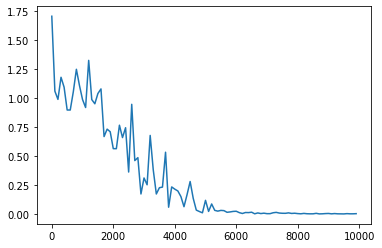

In [ ]:

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
# グラフの表示
plt.show()

# 終わり

In [ ]:
#終了時刻
finish_time = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
print("finish_time=",finish_time)
print("total_time=",finish_time-start_time)


finish_time= 2021-05-04 10:31:48.803293+09:00
total_time= 0:00:36.787577
